## Análises estatísticas do Worlds LOL:

Alunos:
    
    Bruno Cavalcanti  -  <bjcc@cin.ufpe.br>
    Deyvson Lazaro    -  <dls4@cin.ufpe.br>
    Ricardo Robson    -  <rrms@cin.ufpe.br>

Nossa proposta é usar a base de dados do jogo League of Legends e identificar relações entre os personagens e seus resultados.

Nesta análise buscamos responder as seguintes hipóteses:
    KDA e Gold estão relacionados com o resultado da partida
    WinRate dos campeões estão relacionádos com o resultado da partida

In [207]:
#Imports usados no projeto

import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randrange, uniform
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress, t
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [225]:
#Lendo csvs sobre partidas e campoões
winRate_role = pd.read_csv("csv/winRate_role.csv")
matchs = pd.read_csv("csv/matchs.csv", sep=',')
champions = pd.read_csv('csv/data_champions.csv', sep=',')
matchs = matchs.drop('Unnamed: 0', 1)
champions = champions.drop('Unnamed: 0', 1)
champions['champion'] = champions.champion.apply(lambda x: x.capitalize())
matchs['champion1'], matchs['champion2'], matchs['champion3'], matchs['champion4'], matchs['champion5'] = \
    matchs.champion1.apply(lambda x: x.capitalize()), \
    matchs.champion2.apply(lambda x: x.capitalize()), \
    matchs.champion3.apply(lambda x: x.capitalize()), \
    matchs.champion4.apply(lambda x: x.capitalize()), \
    matchs.champion5.apply(lambda x: x.capitalize())

In [209]:
#Criando dataframe com os winrates dos campeões

matchs_winRate = matchs.drop('team', 1)
for a in matchs_winRate.index:
    matchs_winRate.champion1[a]=champions.winRate.loc[(champions['champion']==matchs.champion1[a])\
                                                      & (champions['role']=='Top')].values[0]
    matchs_winRate.champion2[a]=champions.winRate.loc[(champions['champion']==matchs.champion2[a])\
                                                     & (champions['role']=='Jungle')].values[0]
    matchs_winRate.champion3[a]=champions.winRate.loc[(champions['champion']==matchs.champion3[a])\
                                                     & (champions['role']=='Middle')].values[0]
    matchs_winRate.champion4[a]=champions.winRate.loc[(champions['champion']==matchs.champion4[a])\
                                                     & (champions['role']=='ADC')].values[0]
    matchs_winRate.champion5[a]=champions.winRate.loc[(champions['champion']==matchs.champion5[a])\
                                                     & ((champions['role']=='Support') |\
                                                        (champions['role']=='Top'))].values[0]
matchs_winRate.status1 = matchs_winRate["status1"].replace(['   DEFEAT   '], 0)
matchs_winRate.status1 = matchs_winRate["status1"].replace(['   VICTORY   '], 1)

/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyW

In [210]:
#Criando dataframe com os kda's dos campeões

matchs_kda = matchs.drop('team', 1)

for a in matchs_kda.index:
    matchs_kda.champion1[a]=(champions.kills.loc[(champions['champion']==matchs.champion1[a])\
                                                      & (champions['role']=='Top')].values[0]) - \
    (champions.death.loc[(champions['champion']==matchs.champion1[a]) & (champions['role']=='Top')].values[0]) +\
     (champions.assist.loc[(champions['champion']==matchs.champion1[a]) & (champions['role']=='Top')].values[0])
    matchs_kda.champion2[a]=(champions.kills.loc[(champions['champion']==matchs.champion2[a])\
                                                     & (champions['role']=='Jungle')].values[0]) - \
    (champions.death.loc[(champions['champion']==matchs.champion2[a])\
                                                     & (champions['role']=='Jungle')].values[0]) + \
    (champions.assist.loc[(champions['champion']==matchs.champion2[a]) & (champions['role']=='Jungle')].values[0])
    matchs_kda.champion3[a]=(champions.kills.loc[(champions['champion']==matchs.champion3[a])\
                                                     & (champions['role']=='Middle')].values[0]) - \
    (champions.death.loc[(champions['champion']==matchs.champion3[a])\
                                                     & (champions['role']=='Middle')].values[0]) +\
    (champions.assist.loc[(champions['champion']==matchs.champion3[a]) & (champions['role']=='Middle')].values[0])
    matchs_kda.champion4[a]=(champions.kills.loc[(champions['champion']==matchs.champion4[a])\
                                                     & (champions['role']=='ADC')].values[0]) - \
    (champions.death.loc[(champions['champion']==matchs.champion4[a])\
                                                     & (champions['role']=='ADC')].values[0]) + \
    (champions.assist.loc[(champions['champion']==matchs.champion4[a]) & (champions['role']=='ADC')].values[0])
    matchs_kda.champion5[a]=(champions.kills.loc[(champions['champion']==matchs.champion5[a])\
                                                     & ((champions['role']=='Support') |\
                                                        (champions['role']=='Top'))].values[0]) -\
    (champions.death.loc[(champions['champion']==matchs.champion5[a])\
                                                     & ((champions['role']=='Support') |\
                                                        (champions['role']=='Top'))].values[0])
    (champions.assist.loc[(champions['champion']==matchs.champion5[a]) & ((champions['role']=='Support') |\
                                                                          (champions['role']=='Top'))].values[0])

/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rcrdrobson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarn

In [211]:
matchs_kda.status1 = matchs_winRate["status1"].replace(['defeat'], 0)
matchs_kda.status1 = matchs_winRate["status1"].replace(['victory'], 1)

In [212]:
matchs_analisys = pd.DataFrame(index=range(58),columns=["winRate", "result", "gold", "kda"])
for a in matchs_winRate.index:
    matchs_analisys.winRate[a]=np.mean([matchs_winRate["champion1"][a], matchs_winRate["champion2"][a],\
                                       matchs_winRate["champion3"][a], matchs_winRate["champion4"][a],\
                                       matchs_winRate["champion5"][a]], dtype=np.float64)
    matchs_analisys.result[a]=matchs_winRate.status1[a]
    matchs_analisys.gold[a]=matchs_winRate.gold[a]
    matchs_analisys.kda[a]=np.mean([matchs_kda["champion1"][a], matchs_kda["champion2"][a],\
                                       matchs_kda["champion3"][a], matchs_kda["champion4"][a],\
                                       matchs_kda["champion5"][a]], dtype=np.float64)
x=matchs_analisys.winRate.loc[matchs_analisys["result"]==0].values    
y=matchs_analisys.winRate.loc[matchs_analisys["result"]==1].values
matchs_analisys1 = pd.DataFrame(x, columns=["winRate"])
matchs_analisys2 = pd.DataFrame(y, columns=["winRate"])
matchs_analisys1["goldEarned"]=matchs_analisys.gold.loc[matchs_analisys["result"]==0].values    
matchs_analisys2["goldEarned"]=matchs_analisys.gold.loc[matchs_analisys["result"]==1].values
matchs_analisys1["kda"]=matchs_analisys.kda.loc[matchs_analisys["result"]==0].values    
matchs_analisys2["kda"]=matchs_analisys.kda.loc[matchs_analisys["result"]==1].values

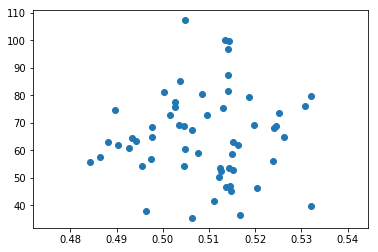

In [213]:
aux = matchs_analisys1.append(matchs_analisys2)
fig = plt.subplots(1,figsize=(6,4)) 
plt.scatter(x=aux['winRate'], y=aux['goldEarned'])

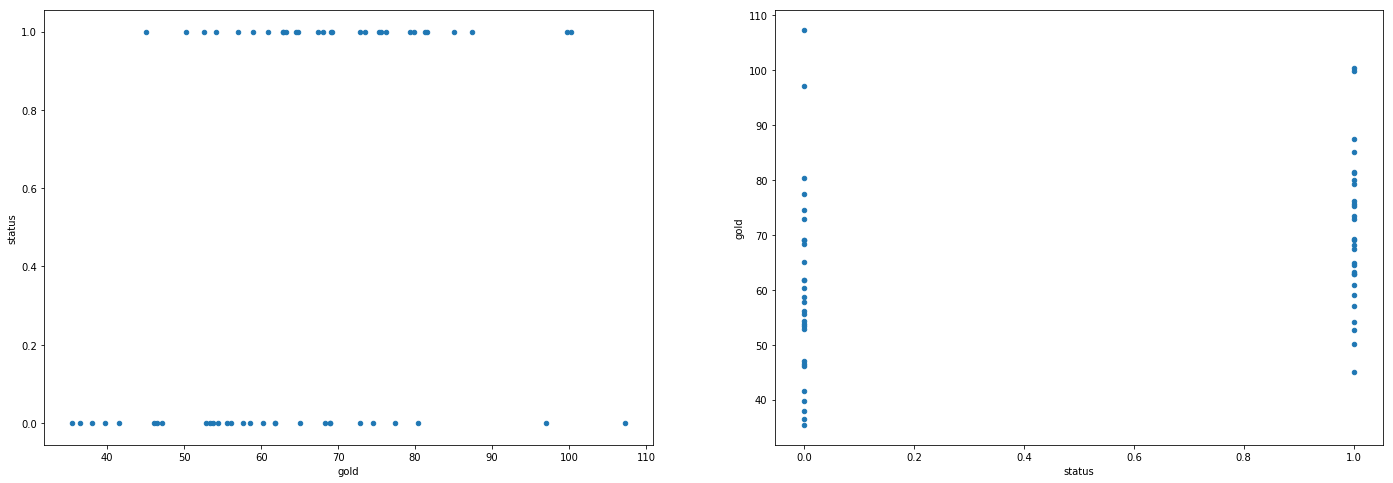

In [214]:
figs, axes = plt.subplots(1,2,figsize=(24,8))
winRate_role[['status','gold']].plot.scatter(y='status',x='gold',ax=axes[0])
winRate_role[['status','gold']].plot.scatter(x='status',y='gold',ax=axes[1])

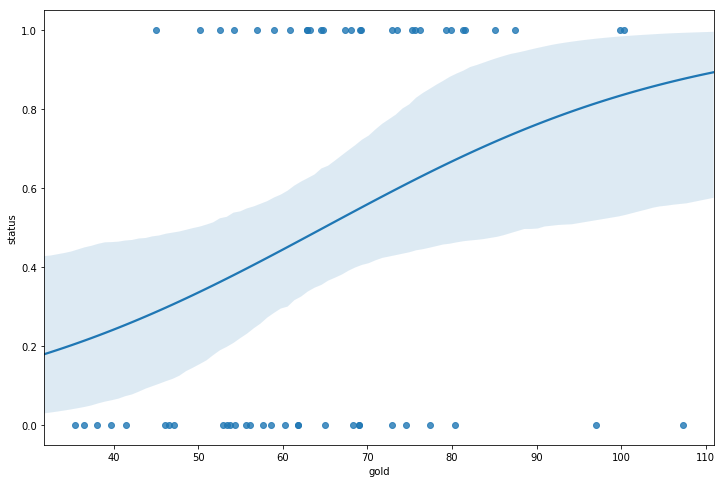

In [215]:
fig, axes = plt.subplots(1,1,figsize=(12,8))
sns.regplot(y='status',x='gold',logistic=True,data=winRate_role,ax=axes)

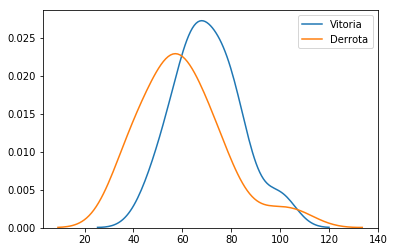

In [216]:
sns.kdeplot(winRate_role[winRate_role['status']==1].gold,label='Vitoria')
sns.kdeplot(winRate_role[winRate_role['status']==0].gold,label='Derrota')

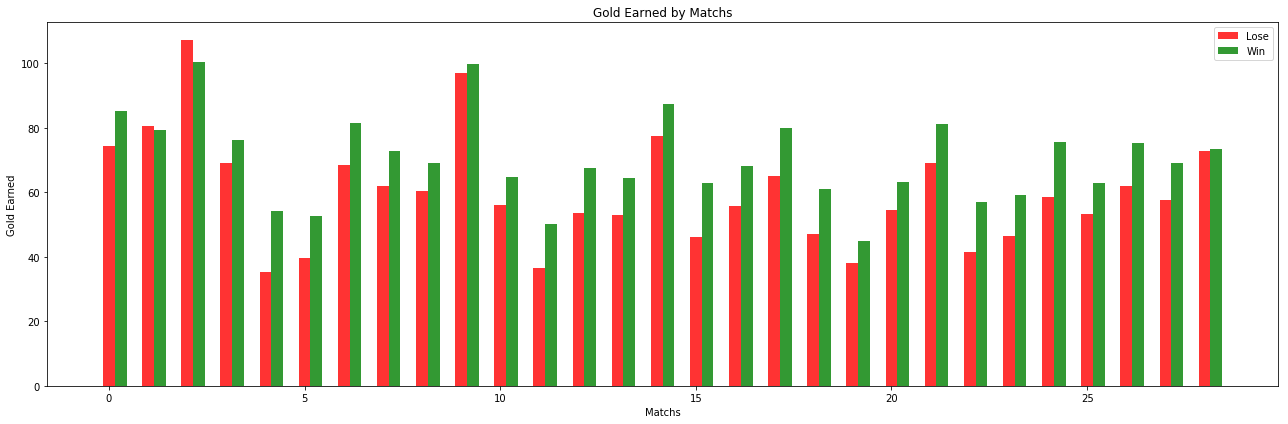

In [217]:
N = 29
winRate1 = np.array(matchs_analisys1['goldEarned'])
winRate2 = np.array(matchs_analisys2['goldEarned'])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('Gold Earned')
plt.title('Gold Earned by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [244]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]<=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de gold farmado em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de gold farmado maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  27	Derrotas:  2
Percentual de gold farmado em derrota:	6.896551724137931
Percentual de gold farmado maior em Vitoria:	93.10344827586206


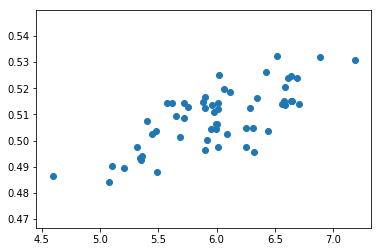

In [245]:
aux = matchs_analisys1.append(matchs_analisys2)
aux.head()

fig = plt.subplots(1,figsize=(6,4)) 
plt.scatter(x=aux['kda'], y=aux['winRate'])

In [246]:
X = aux.kda.values.copy()
y = aux.winRate.values

model = LinearRegression()
model.fit(X[:, np.newaxis],y)
print('y = {:.3f} + {:.3f}x'.format(model.intercept_,model.coef_[0]))
print('Stats')
print('r2 = {:.3f}'.format(r2_score(y,model.predict(X[:, np.newaxis]))))

y = 0.409 + 0.017x
Stats
r2 = 0.543


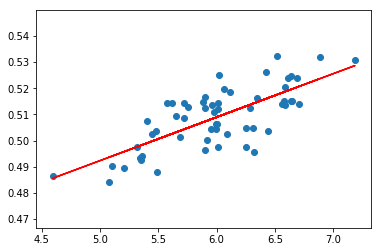

In [247]:
figs, ax = plt.subplots(1,1,figsize=(6,4))
plt.scatter(x=aux['kda'], y=aux['winRate'])
ax.plot(aux.kda,aux.kda.map(lambda x: model.coef_[0]*x+model.intercept_),color='red')

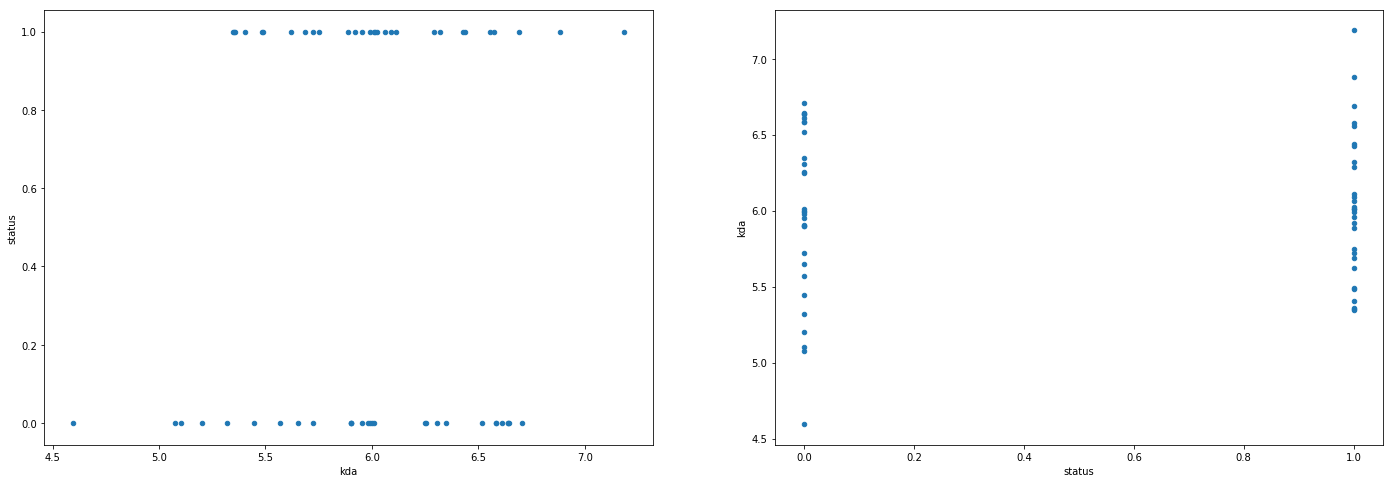

In [251]:
aux = aux.assign(status=winRate_role['status'].values)
aux['kda'] = aux['kda'].apply(pd.to_numeric)

figs, axes = plt.subplots(1,2,figsize=(24,8))
aux[['status','kda']].plot.scatter(y='status',x='kda',ax=axes[0])
aux[['status','kda']].plot.scatter(x='status',y='kda',ax=axes[1])

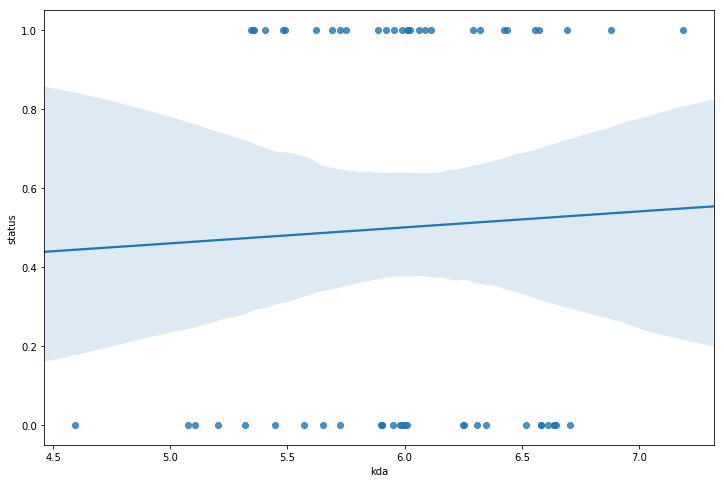

In [250]:
fig, axes = plt.subplots(1,1,figsize=(12,8))
sns.regplot(y='status',x='kda',logistic=True,data=aux,ax=axes)

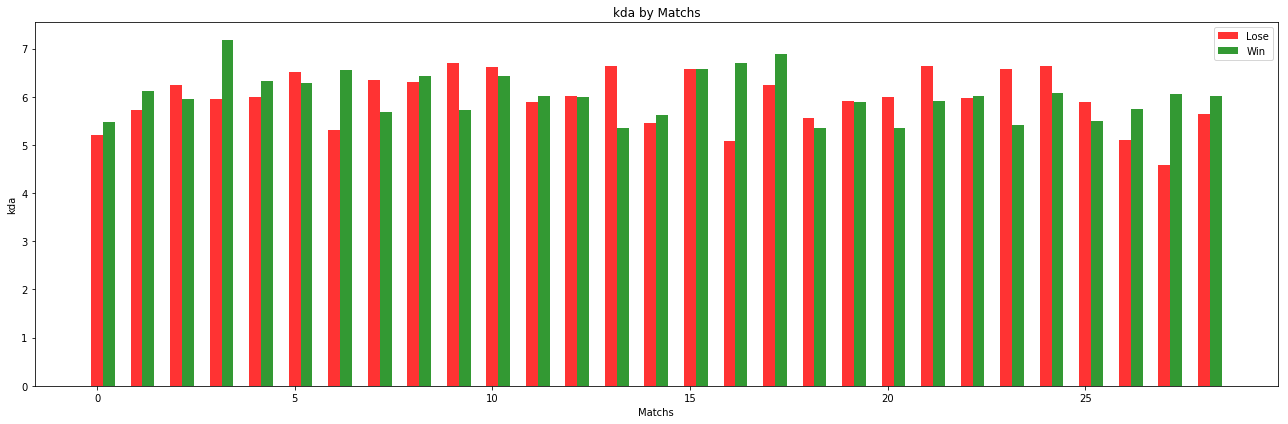

In [252]:
N = 29
winRate1 = np.array(matchs_analisys1['kda'])
winRate2 = np.array(matchs_analisys2['kda'])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('kda')
plt.title('kda by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [253]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]<=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de KDA maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de KDA maior em vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  14	Derrotas:  15
Percentual de KDA maior em derrota:	51.724137931034484
Percentual de KDA maior em vitoria:	48.275862068965516


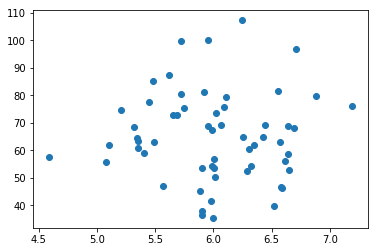

In [254]:
aux = matchs_analisys1.append(matchs_analisys2)
aux.head()

fig = plt.subplots(1,figsize=(6,4))
plt.scatter(x=aux['kda'], y=aux['goldEarned'])

In [257]:
x = matchs_winRate.loc[matchs_winRate["status1"]==0].values
y = matchs_winRate.loc[matchs_winRate["status1"]==1].values

matchs_winRate_role0 = pd.DataFrame(x, columns = ["champion1", "champion2", "champion3", "champion4", "champion5", "status", "date", "gold"])
matchs_winRate_role1 = pd.DataFrame(y, columns = ["champion1", "champion2", "champion3", "champion4", "champion5", "status", "date", "gold"])

matchs_winRate_role0.to_csv("csv/winRate_role_lose.csv")
matchs_winRate_role1.to_csv("csv/winRate_role_win.csv")

matchs_analisys1.to_csv("csv/overview_lose.csv")
matchs_analisys1.to_csv("csv/overview_win.csv")

matchs_winRate = matchs_winRate_role0.append(matchs_winRate_role1)
matchs_winRate.to_csv("csv/winRate_role.csv")

matchs_analisys = matchs_analisys1.append(matchs_analisys1)
matchs_analisys.to_csv("csv/overview.csv")

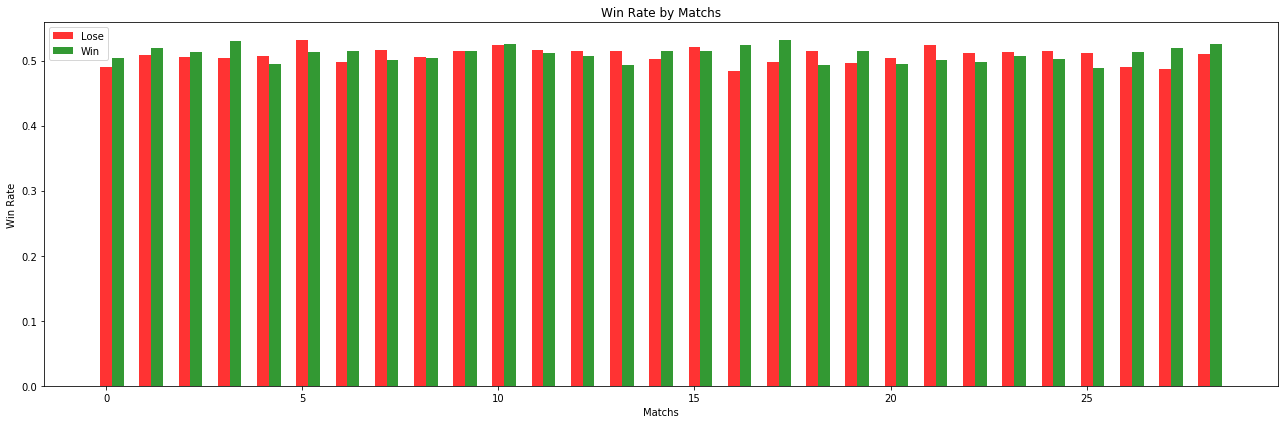

In [258]:
N = 29
winRate1 = np.array(matchs_analisys1['winRate'])
winRate2 = np.array(matchs_analisys2['winRate'])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('Win Rate')
plt.title('Win Rate by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [259]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]>=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de winrate maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de winrate maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  15	Derrotas:  14
Percentual de winrate maior em derrota:	48.275862068965516
Percentual de winrate maior em Vitoria:	51.724137931034484


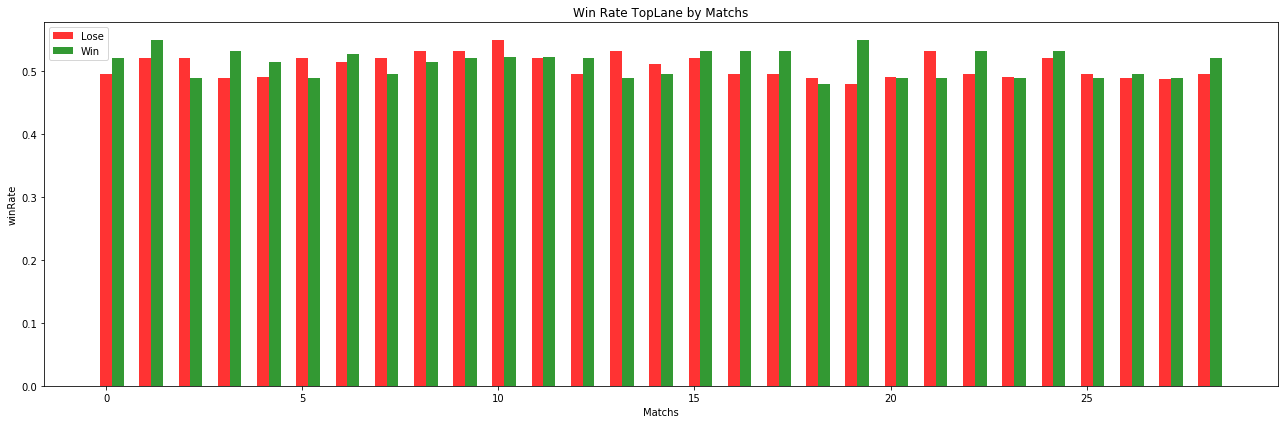

In [260]:
N = 29
winRate1 = np.array(matchs_winRate_role0["champion1"])
winRate2 = np.array(matchs_winRate_role1["champion1"])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('winRate')
plt.title('Win Rate TopLane by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [261]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]>=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de winrate maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de winrate maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  13	Derrotas:  16
Percentual de winrate maior em derrota:	55.172413793103445
Percentual de winrate maior em Vitoria:	44.827586206896555


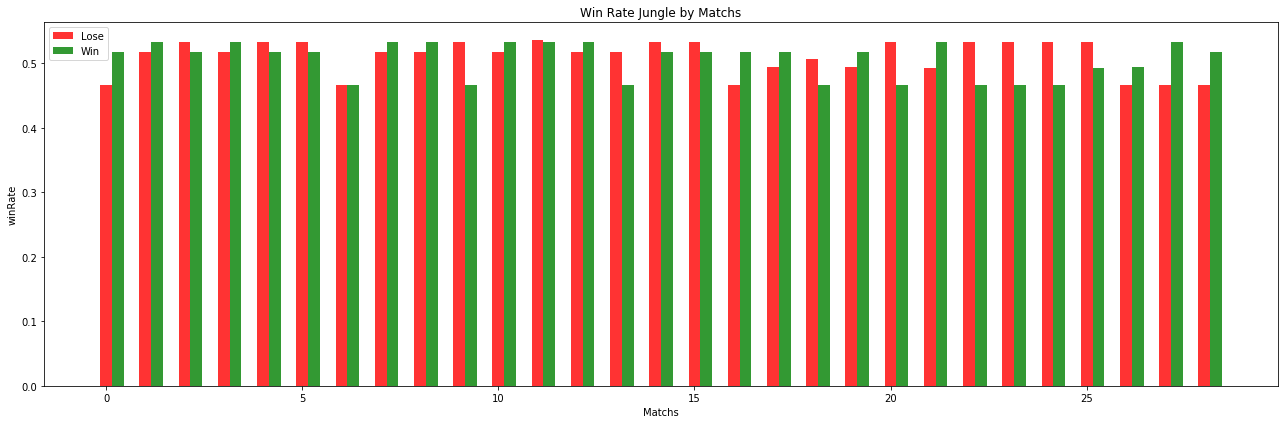

In [262]:
N = 29
winRate1 = np.array(matchs_winRate_role0["champion2"])
winRate2 = np.array(matchs_winRate_role1["champion2"])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('winRate')
plt.title('Win Rate Jungle by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [263]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]>=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de winrate maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de winrate maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  14	Derrotas:  15
Percentual de winrate maior em derrota:	51.724137931034484
Percentual de winrate maior em Vitoria:	48.275862068965516


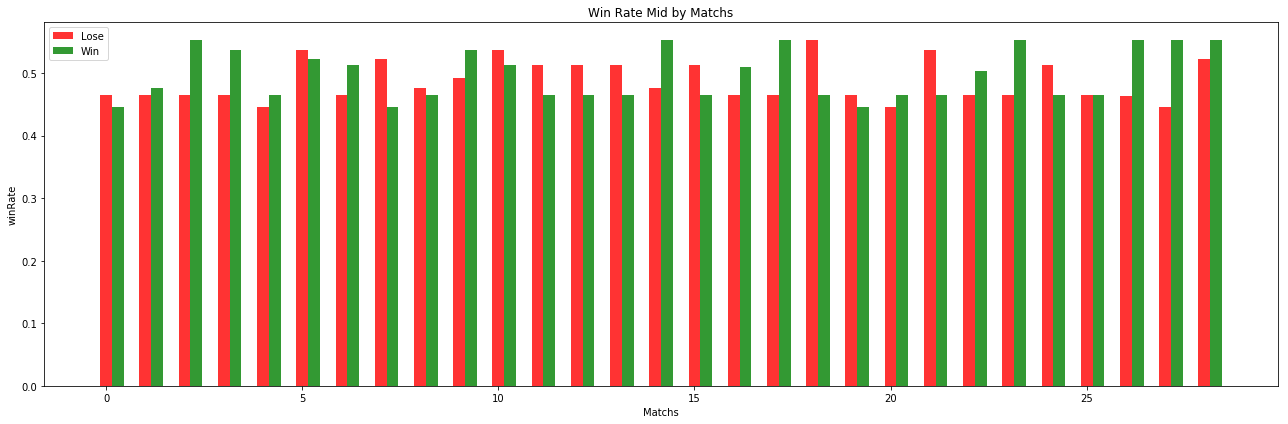

In [264]:
N = 29
winRate1 = np.array(matchs_winRate_role0["champion3"])
winRate2 = np.array(matchs_winRate_role1["champion3"])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('winRate')
plt.title('Win Rate Mid by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [265]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]>=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de winrate maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de winrate maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  14	Derrotas:  15
Percentual de winrate maior em derrota:	51.724137931034484
Percentual de winrate maior em Vitoria:	48.275862068965516


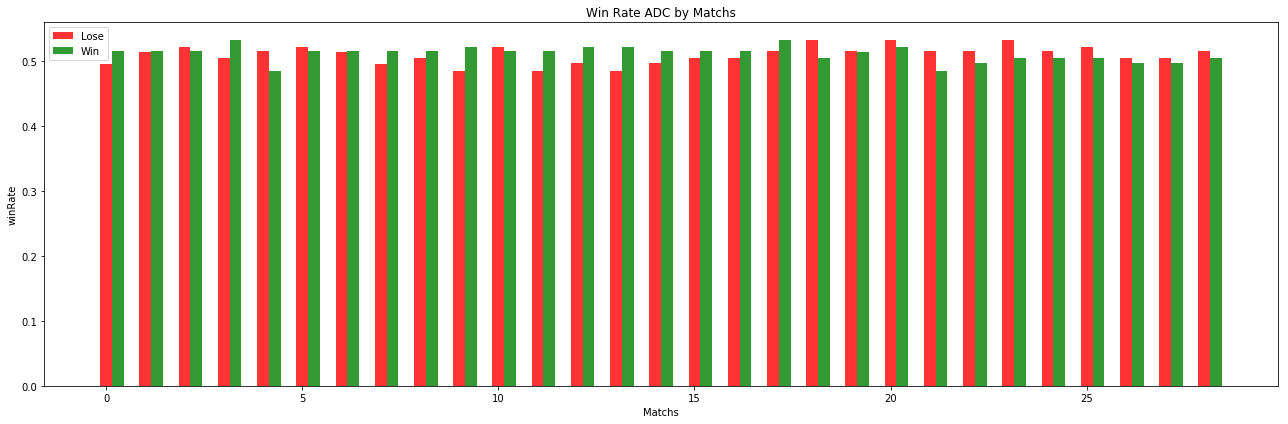

In [266]:
N = 29
winRate1 = np.array(matchs_winRate_role0["champion4"])
winRate2 = np.array(matchs_winRate_role1["champion4"])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('winRate')
plt.title('Win Rate ADC by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [267]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]>=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de winrate maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de winrate maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  15	Derrotas:  14
Percentual de winrate maior em derrota:	48.275862068965516
Percentual de winrate maior em Vitoria:	51.724137931034484


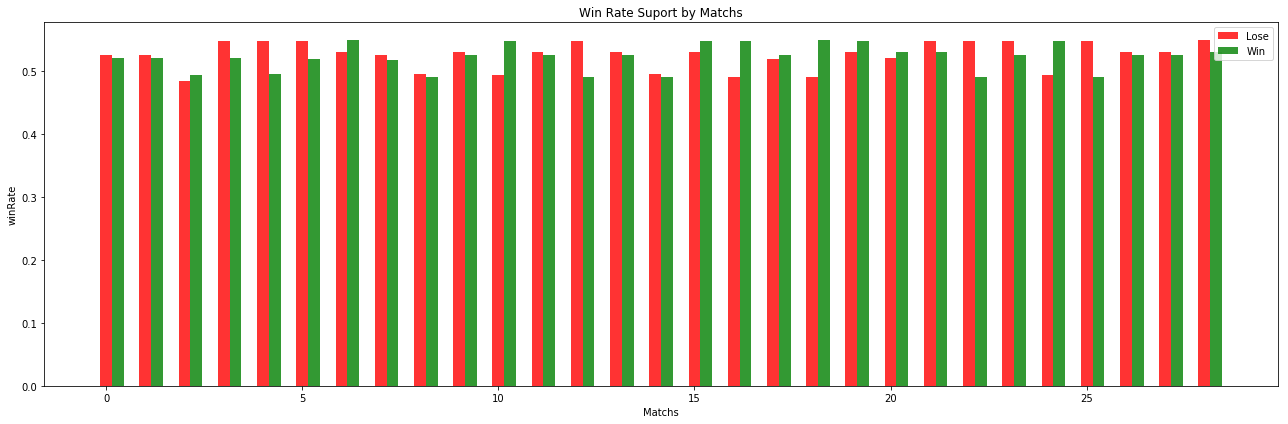

In [268]:
N = 29
winRate1 = np.array(matchs_winRate_role0["champion5"])
winRate2 = np.array(matchs_winRate_role1["champion5"])
width = 0.30

fig, ax = plt.subplots(figsize=(18,6))
index = np.arange(N)
opacity = 0.8

rects1 = plt.bar(index, winRate1, width,
                 alpha=opacity,
                 color='r',
                 label='Lose')
 
rects2 = plt.bar(index + width, winRate2, width,
                 alpha=opacity,
                 color='g',
                 label='Win')

plt.xlabel('Matchs')
plt.ylabel('winRate')
plt.title('Win Rate Suport by Matchs')
plt.legend()
 
plt.tight_layout()
plt.show()

In [269]:
qtdWin = 0
qtdLose = 0
for index, value in enumerate(winRate1):
    if(winRate1[index]>=winRate2[index]):
        qtdWin = qtdWin + 1
    else:
        qtdLose = qtdLose + 1
        
print("Vitórias:  "+str(qtdWin)+"\tDerrotas:  "+str(qtdLose))
print("Percentual de winrate maior em derrota:\t"+str(qtdLose/(qtdLose+qtdWin)*100))
print("Percentual de winrate maior em Vitoria:\t"+str(qtdWin/(qtdLose+qtdWin)*100))

Vitórias:  19	Derrotas:  10
Percentual de winrate maior em derrota:	34.48275862068966
Percentual de winrate maior em Vitoria:	65.51724137931035


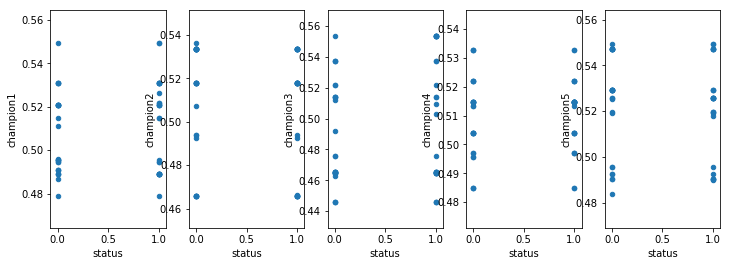

In [270]:
figs, axes = plt.subplots(1,5,figsize=(12,4))
winRate_role[['status','champion1']].plot.scatter(x='status',y='champion1',ax=axes[0])
winRate_role[['status','champion2']].plot.scatter(x='status',y='champion2',ax=axes[1])
winRate_role[['status','champion3']].plot.scatter(x='status',y='champion3',ax=axes[2])
winRate_role[['status','champion4']].plot.scatter(x='status',y='champion4',ax=axes[3])
winRate_role[['status','champion5']].plot.scatter(x='status',y='champion5',ax=axes[4])

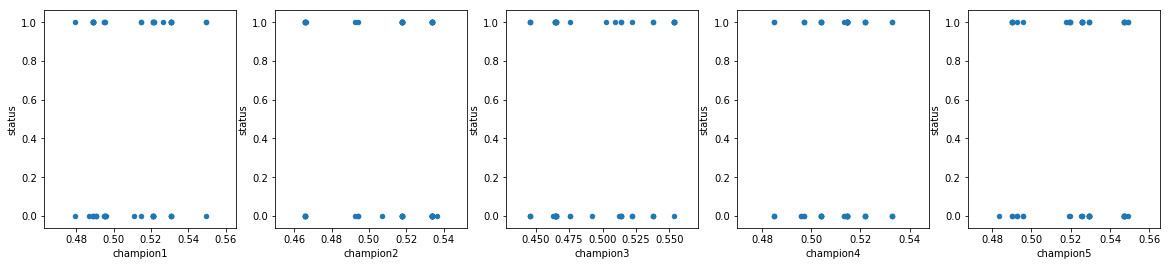

In [271]:
figs, axes = plt.subplots(1,5,figsize=(20,4))
winRate_role[['status','champion1']].plot.scatter(y='status',x='champion1',ax=axes[0])
winRate_role[['status','champion2']].plot.scatter(y='status',x='champion2',ax=axes[1])
winRate_role[['status','champion3']].plot.scatter(y='status',x='champion3',ax=axes[2])
winRate_role[['status','champion4']].plot.scatter(y='status',x='champion4',ax=axes[3])
winRate_role[['status','champion5']].plot.scatter(y='status',x='champion5',ax=axes[4])

In [272]:
model = smf.logit("status ~ champion1 + champion2 + champion3 + champion4 + champion5",winRate_role).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.668072
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                   58
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            5
Date:                Tue, 12 Dec 2017   Pseudo R-squ.:                 0.03618
Time:                        21:00:49   Log-Likelihood:                -38.748
converged:                       True   LL-Null:                       -40.203
                                        LLR p-value:                    0.7141
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5148     15.675     -0.479      0.632     -38.236      23.207
champion1     13.4377     14.797      0.908      0.364     -15.564      42.439
champion2     -9.7227     10.638     -0.914      0.361     -30.572      11.126
champion3      6.9059      7.480      0.923      0.356      -7.754      21.566
champion4     11.1805     21.910      0.510      0.610     -31.762      54.123
champion5     -6.6775     13.265     -0.503      0.615     -32.677      19.322
==============================================================================
"""

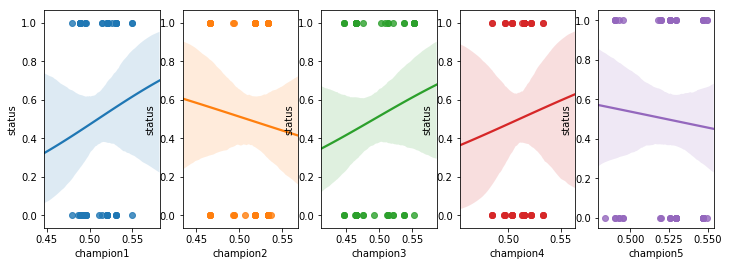

In [273]:
fig, axes = plt.subplots(1,5,figsize=(12,4))
sns.regplot(y='status',x='champion1',logistic=True,data=winRate_role,ax=axes[0])
sns.regplot(y='status',x='champion2',logistic=True,data=winRate_role,ax=axes[1])
sns.regplot(y='status',x='champion3',logistic=True,data=winRate_role,ax=axes[2])
sns.regplot(y='status',x='champion4',logistic=True,data=winRate_role,ax=axes[3])
sns.regplot(y='status',x='champion5',logistic=True,data=winRate_role,ax=axes[4])

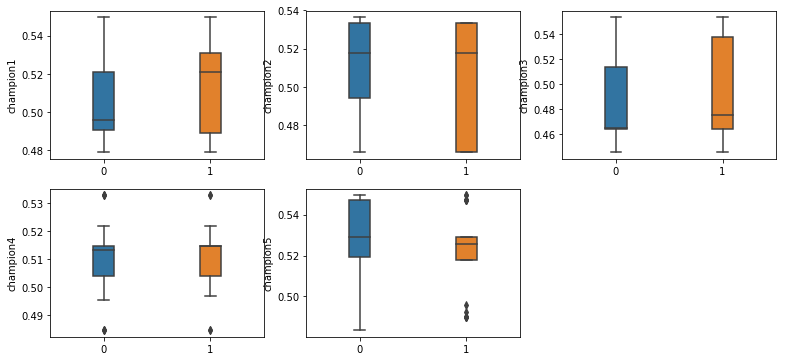

In [274]:
fig, axes = plt.subplots(2,3,figsize=(13,6))
sns.boxplot(x='status',y='champion1',data=winRate_role,ax=axes[0][0],width=.2)
sns.boxplot(x='status',y='champion2',data=winRate_role,ax=axes[0][1],width=.2)
sns.boxplot(x='status',y='champion3',data=winRate_role,ax=axes[0][2],width=.2)
sns.boxplot(x='status',y='champion4',data=winRate_role,ax=axes[1][0],width=.2)
sns.boxplot(x='status',y='champion5',data=winRate_role,ax=axes[1][1],width=.2)
#sns.boxplot(x='prognostico',y=prostate.prognostico.value_counts(),data=prostate,ax=axes[1][2])
axes[0][0].xaxis.label.set_visible(False)
axes[0][1].xaxis.label.set_visible(False)
axes[0][2].xaxis.label.set_visible(False)
axes[1][0].xaxis.label.set_visible(False)
axes[1][1].xaxis.label.set_visible(False)
fig.delaxes(axes[1][2])

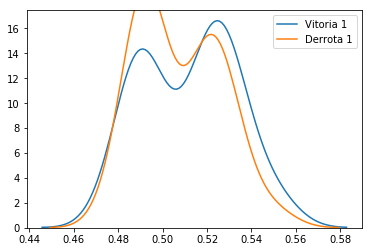

In [275]:
sns.kdeplot(winRate_role[winRate_role['status']==1].champion1,label='Vitoria 1')
sns.kdeplot(winRate_role[winRate_role['status']==0].champion1,label='Derrota 1')

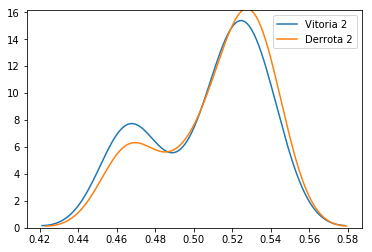

In [276]:
sns.kdeplot(winRate_role[winRate_role['status']==1].champion2,label='Vitoria 2')
sns.kdeplot(winRate_role[winRate_role['status']==0].champion2,label='Derrota 2')

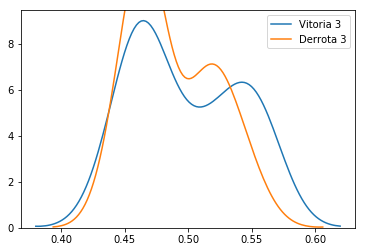

In [277]:
sns.kdeplot(winRate_role[winRate_role['status']==1].champion3,label='Vitoria 3')
sns.kdeplot(winRate_role[winRate_role['status']==0].champion3,label='Derrota 3')

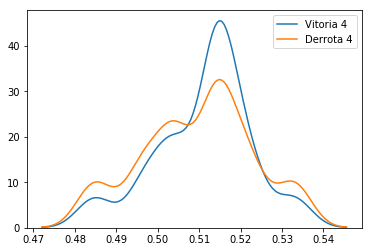

In [278]:
sns.kdeplot(winRate_role[winRate_role['status']==1].champion4,label='Vitoria 4')
sns.kdeplot(winRate_role[winRate_role['status']==0].champion4,label='Derrota 4')

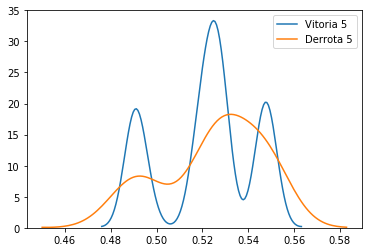

In [279]:
sns.kdeplot(winRate_role[winRate_role['status']==1].champion5,label='Vitoria 5')
sns.kdeplot(winRate_role[winRate_role['status']==0].champion5,label='Derrota 5')